In [1]:
#importamos las librerias que vamos a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn. decomposition import PCA
from sklearn.preprocessing import LabelEncoder



In [2]:
#Ahora cargamos los datos que vamos a utilizar
data = pd.read_csv("costumer-segmentation.csv")
#vamos a eliminar la columna segmentation
data = data.drop(["Segmentation"], axis = 'columns')

In [3]:
#vamos a quitar lo que no nos sirva de la base de datos 
data.drop(["ID"],axis = 'columns', inplace = True)

In [4]:
data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6


Ya que se quitaron las columnas que no nos van a servir para el analisis vamos a hacer un analisis exploratorio de los datos, primero viendo si existen datos faltantes, luego de esa revision veremos si las variables numericas presentas outliers de los que nos debamos preocupar o en su defecto identificar si solo se trata de valores extremos que no afectaran al analisis.

In [5]:
#datos faltantes
data.isnull().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64

Con lo anterior obtuvimos el total de valores faltantes para cada variable donde se tiene que para las columnas "Gender","Age","Spending_Score" no se tiene ningun valor faltante mientras que las demas variables si presentan valores faltantes siendo "Work_Eperience" la que mas presenta este problema. 

In [6]:
#Ahora vamos a transformar las variables categoricas a numericas para poder trabajarlas
pd.options.mode.copy_on_write = True
data_cat = data[["Gender","Ever_Married","Graduated","Profession","Spending_Score","Var_1"]]
encoders = {}
for col_name in data_cat.columns:
    series = data_cat[col_name]
    label_encoder = LabelEncoder()
    data_cat[col_name] = pd.Series(label_encoder.fit_transform(series[series.notnull()]),
    index = series[series.notnull()].index)
    encoders[col_name] = label_encoder

In [7]:
# para poder manejar bien los datos vamos a usar knn para ambos casos de los datos, i.e.,
#para los categorico y para los numericos
pd.options.mode.copy_on_write = True
data_num = data[['Age','Work_Experience','Family_Size']]
imputer = KNNImputer(n_neighbors = 5)
data_num.loc[:] = imputer.fit_transform(data_num)
#para los categoricos
imputer = KNNImputer(n_neighbors = 1)
data_cat.loc[:] = imputer.fit_transform(data_cat)
# ya que se procesaron los datos vamos a concatenarlos 
data = pd.concat([data_cat,data_num], axis = 1)

C:\Users\Leobardo\AppData\Local\Temp\ipykernel_20724\3758409191.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_num.loc[:] = imputer.fit_transform(data_num)
C:\Users\Leobardo\AppData\Local\Temp\ipykernel_20724\3758409191.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_cat.loc[:] = imputer.fit_transform(data_cat)


In [8]:
#Ahora ya con los datos procesados vamos a utilizar PCA 
pca = PCA(2)
#procedemos a transformar la informacion 
df = pca.fit_transform(data)
df.shape

(8068, 2)

Por la naturaleza de los datos decidimos que vamos a uitilizar el metodo de K-prototypes
para hacer la clusterizacion, asi que tendremos que procesar la informacion de forma adecuada para lograr hacer esto.

In [9]:
# vamos a decodificar la informacion
for i in data_cat.columns:
    data[i] = data[i].astype(int)
for col_name in data_cat.columns:
    data[col_name] = encoders[col_name]. inverse_transform(data[col_name])

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     8068 non-null   object 
 2   Graduated        8068 non-null   object 
 3   Profession       8068 non-null   object 
 4   Spending_Score   8068 non-null   object 
 5   Var_1            8068 non-null   object 
 6   Age              8068 non-null   float64
 7   Work_Experience  8068 non-null   float64
 8   Family_Size      8068 non-null   float64
dtypes: float64(3), object(6)
memory usage: 567.4+ KB


Ya que se hizo el preprocesamiento de los datos procederemos a implementar el algoritmo de clusterizacion K-prototypes.

In [11]:
# ahora vamos a tomar la poscion de las variables categoricas
columns_position = [data.columns.get_loc(col) for col in list(data.select_dtypes('object').columns)]

print('Columnas categoricas:{}'.format(list(data.select_dtypes('object').columns)))
print('Posicion de columnas categoricas:{}'.format(columns_position))

Columnas categoricas:['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
Posicion de columnas categoricas:[0, 1, 2, 3, 4, 5]


In [12]:
# ya que sabemos la posicion y nombre de las variables de tipo categoricas vamos a convertir 
#el data frame en una matriz
matrix = data.to_numpy()

Ya con la informacion transformada a formato de matriz vamos a emplear el algoritmo, pero para esto debemos mencionar que utilizaremos el metodo del codo o Elbow para determinar el numero k de clusters.

In [13]:
#pip install kmodes

Initialization of cluster: 1
Initialization of cluster: 2
Initialization of cluster: 3
Initialization of cluster: 4
Initialization of cluster: 5
Initialization of cluster: 6
Initialization of cluster: 7
Initialization of cluster: 8
Initialization of cluster: 9


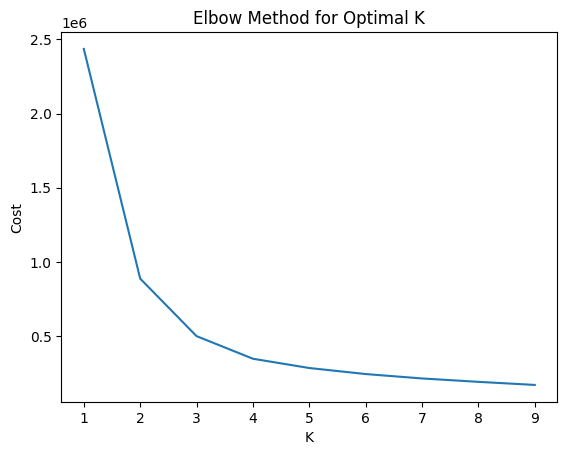

In [17]:
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt

cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_clusters=cluster, init="Huang", n_jobs=-1, random_state=0)
        kprototype.fit_predict(matrix, categorical=columns_position)
        cost.append(kprototype.cost_)
        print('Initialization of cluster: {}'.format(cluster))
    except Exception as e:
        print(e)
        break

plt.plot(range(1, len(cost) + 1), cost)
plt.xlabel('K')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal K')
plt.show()

In [15]:
#pip install kneed

In [18]:
from kneed import KneeLocator
cost_knee3 = KneeLocator(x = range(1,10), y = cost, S = 0.1, curve = 'convex',
                         direction = 'decreasing', online = True)
k_cost3 = cost_knee3.elbow
print('Elbow para k = ', f'{k_cost3:.0f} clusters')


Elbow para k =  3 clusters


In [19]:
#con los resultados obtenidos vamos a utilizar k = 3
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
data['clusters'] = kprototype.fit_predict(matrix, categorical = columns_position)

Ya que obtuvimos el valor K para el numero de clusters los graficaremos para ver como quedaron.

In [20]:
label = kprototype.fit_predict(matrix, categorical = columns_position)
print(label)

[1 2 0 ... 1 1 2]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

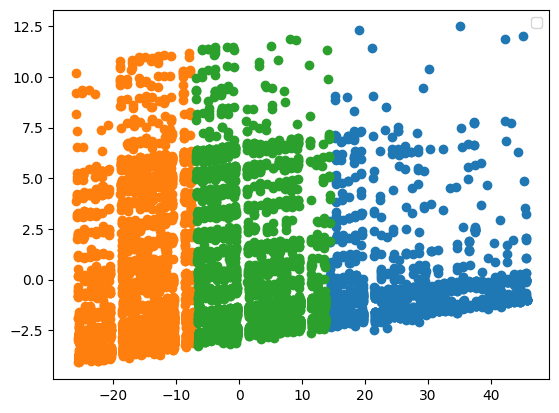

In [21]:
labels_unicos = np.unique(label)
#graficamos los resultados
for i in labels_unicos:
    plt.scatter(df[label == i, 0], df[label == i, 1])
plt.legend()
plt.show

Ya que se obtuvieronlos clusters vamos a analizar un poco estos con el fin de ver que nos aportan.

Text(0.5, 1.0, 'Clusters')

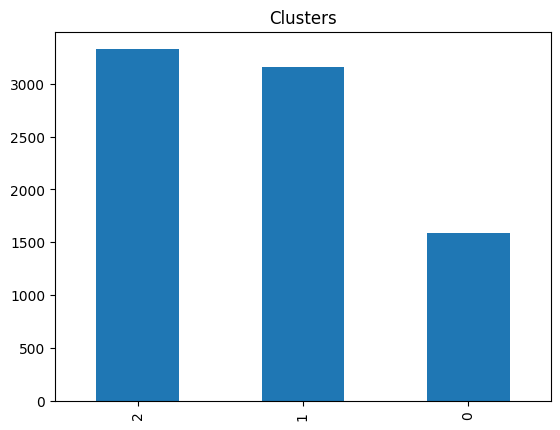

In [22]:
data['clusters'].value_counts().plot(kind = 'bar')
plt.title('Clusters')

Podemos observar que de los 3 clusters el mas importante fue el segundo, seguido del primer cluster y por ultimo el cluster 0.

In [23]:
#Estadisticas
data.groupby(['clusters']).mean() #media de cada cluster por variable numerica

C:\Users\Leobardo\AppData\Local\Temp\ipykernel_20724\229690348.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby(['clusters']).mean() #media de cada cluster por variable numerica


,Age,Work_Experience,Family_Size
clusters,,,
0,70.184442,1.365872,2.262861
1,27.856916,3.180330,3.322081
2,45.458158,2.732992,2.695485


In [24]:
data.groupby(['clusters']).agg(lambda x: pd.Series.mode(x).iat[0])[['Gender','Ever_Married','Profession','Spending_Score','Var_1']]

,Gender,Ever_Married,Profession,Spending_Score,Var_1
clusters,,,,,
0,Male,Yes,Lawyer,Low,Cat_6
1,Male,No,Healthcare,Low,Cat_6
2,Male,Yes,Artist,Low,Cat_6
